
*   Balancing the best using all 3 under,over,smote,bagging
*   Find Best Parameter for LGR,DT,RF,ADA,GB,SVC,KNN,balanced using optuna
*   Combine them to find Stacking see if accuracy improves
*   Voting classifier using those parameters




In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier,GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score
from imblearn.over_sampling import SMOTE,RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.ensemble import BalancedRandomForestClassifier

In [2]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 15.7 MB/s eta 0:00:00


In [3]:
import optuna

In [4]:
from sklearn.model_selection import cross_val_score

In [5]:
df = pd.read_csv('/content/Titanic.csv')

In [6]:
x = df.drop('Survived',axis=1)
y = df['Survived']

In [7]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)

In [8]:
ds = RandomUnderSampler(random_state=42)
x_train_ds,y_train_ds = ds.fit_resample(x_train,y_train)

In [9]:
sm = SMOTE(random_state=42)
x_train_sm,y_train_sm = sm.fit_resample(x_train,y_train)


In [10]:
lg = LogisticRegression()
lg.fit(x_train_ds,y_train_ds)
y_pred = lg.predict(x_test)
print(accuracy_score(y_test,y_pred))
print(confusion_matrix(y_test,y_pred)) #0.7988,78 simple, 81,78 on ds, 80,78,,,
print(cross_val_score(lg,x_train,y_train,cv=3,scoring='accuracy').mean())

0.8100558659217877
[[81 24]
 [10 64]]
0.7823044829746245


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

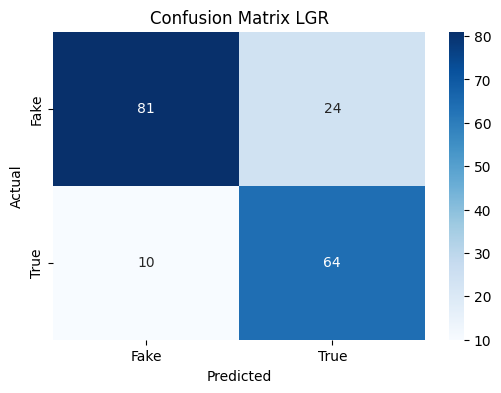

In [13]:
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, fmt="d", cmap="Blues", xticklabels=["Fake", "True"], yticklabels=["Fake", "True"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix LGR")
plt.show()

In [70]:
from sklearn.model_selection import cross_val_score

def objective_logreg(trial):
    C = trial.suggest_float('C', 1e-3, 1e2, log=True)
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    solver = 'liblinear' if penalty == 'l1' else 'lbfgs'
    class_weight = trial.suggest_categorical('class_weight', [None, 'balanced'])

    model = LogisticRegression(
        C=C, penalty=penalty, solver=solver,
        class_weight=class_weight, max_iter=1000, random_state=42
    )
    score = cross_val_score(model, x_train_sm, y_train_sm, cv=3, scoring='accuracy').mean()
    return score


In [71]:
# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler())  # We aim to maximize accuracy
study.optimize(objective_logreg, n_trials=100)  # Run 50 trials to find the best hyperparameters

[I 2025-09-18 18:56:31,142] A new study created in memory with name: no-name-0a2e280e-501b-46a7-ac02-f1c82ad9a117
[I 2025-09-18 18:56:31,170] Trial 0 finished with value: 0.7882882882882883 and parameters: {'C': 2.2593850716552435, 'penalty': 'l1', 'class_weight': None}. Best is trial 0 with value: 0.7882882882882883.
[I 2025-09-18 18:56:31,238] Trial 1 finished with value: 0.7905405405405407 and parameters: {'C': 85.32347447872236, 'penalty': 'l2', 'class_weight': None}. Best is trial 1 with value: 0.7905405405405407.
[I 2025-09-18 18:56:31,310] Trial 2 finished with value: 0.7905405405405407 and parameters: {'C': 84.4336083503538, 'penalty': 'l2', 'class_weight': 'balanced'}. Best is trial 1 with value: 0.7905405405405407.
[I 2025-09-18 18:56:31,343] Trial 3 finished with value: 0.786036036036036 and parameters: {'C': 0.022986949138059525, 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 1 with value: 0.7905405405405407.
[I 2025-09-18 18:56:31,410] Trial 4 finished with va

In [72]:
print(f'Best trial accuracy: {study.best_trial.value}')
print(f'Best hyperparameters: {study.best_trial.params}') #ds 0.7891, 7995

Best trial accuracy: 0.7995495495495496
Best hyperparameters: {'C': 0.09829405204875347, 'penalty': 'l2', 'class_weight': None}


In [73]:
lgs = LogisticRegression(**study.best_trial.params)
lgs.fit(x_train_sm,y_train_sm)
print(accuracy_score(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

0.8435754189944135
[[88 17]
 [11 63]]


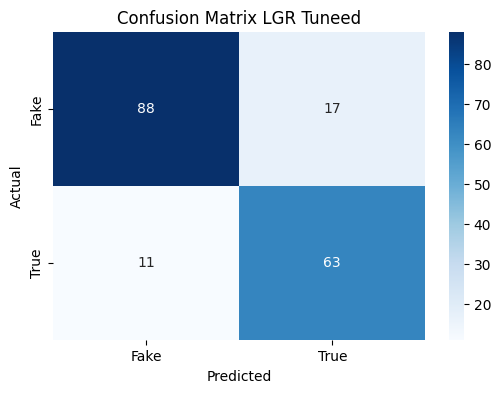

In [74]:
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, fmt="d", cmap="Blues", xticklabels=["Fake", "True"], yticklabels=["Fake", "True"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix LGR Tuneed")
plt.show()

simple gave 0.79 cross val score, down gave 0.78

In [75]:
ad = AdaBoostClassifier()
ad.fit(x_train,y_train)
y_pred = ad.predict(x_test)
print(accuracy_score(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))
print(cross_val_score(ad,x_train,y_train,cv=3,scoring='accuracy').mean()) #79,78---77,78----78.77, 7879

0.7988826815642458
[[89 16]
 [20 54]]
0.7879362715550355


In [78]:
def objective_adaboost(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 2.0)

    base_depth = trial.suggest_int('max_depth', 1, 10)
    base_estimator = DecisionTreeClassifier(max_depth=base_depth, random_state=42)

    model = AdaBoostClassifier(
        estimator=base_estimator,
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        random_state=42
    )
    score = cross_val_score(model, x_train_sm, y_train_sm, cv=3, scoring='accuracy').mean()
    return score

In [79]:
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler())  # We aim to maximize accuracy
study.optimize(objective_adaboost, n_trials=100)  # Run 50 trials to find the best hyperparameters

[I 2025-09-18 18:58:11,993] A new study created in memory with name: no-name-524e1ffa-6167-43ee-a632-fd75df20bb8c
[I 2025-09-18 18:58:12,638] Trial 0 finished with value: 0.8423423423423424 and parameters: {'n_estimators': 95, 'learning_rate': 0.7415965910610888, 'max_depth': 4}. Best is trial 0 with value: 0.8423423423423424.
[I 2025-09-18 18:58:13,699] Trial 1 finished with value: 0.8355855855855857 and parameters: {'n_estimators': 141, 'learning_rate': 0.015326877074492921, 'max_depth': 6}. Best is trial 0 with value: 0.8423423423423424.
[I 2025-09-18 18:58:19,341] Trial 2 finished with value: 0.8277027027027027 and parameters: {'n_estimators': 470, 'learning_rate': 0.17072853607530789, 'max_depth': 10}. Best is trial 0 with value: 0.8423423423423424.
[I 2025-09-18 18:58:19,901] Trial 3 finished with value: 0.8063063063063064 and parameters: {'n_estimators': 91, 'learning_rate': 0.17012384146123877, 'max_depth': 2}. Best is trial 0 with value: 0.8423423423423424.
[I 2025-09-18 18:58

In [80]:
print(f'Best trial accuracy: {study.best_trial.value}')
print(f'Best hyperparameters: {study.best_trial.params}') #81.74 on simple , 78.92 ds, 0.84

Best trial accuracy: 0.8457207207207208
Best hyperparameters: {'n_estimators': 326, 'learning_rate': 0.5115432673589696, 'max_depth': 4}


In [82]:
ads = AdaBoostClassifier(n_estimators=326, learning_rate=0.5115432673589696, estimator=DecisionTreeClassifier(max_depth=4, random_state=42))
ads.fit(x_train_sm,y_train_sm)
print(accuracy_score(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

0.7988826815642458
[[89 16]
 [20 54]]


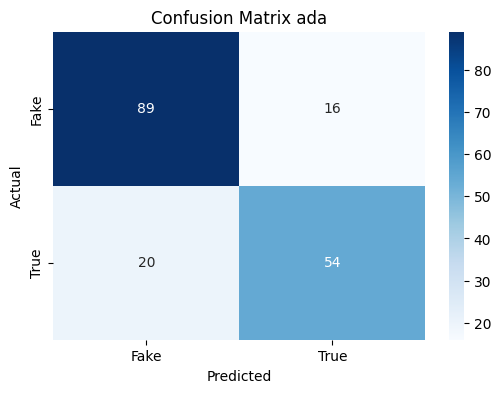

In [84]:
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, fmt="d", cmap="Blues", xticklabels=["Fake", "True"], yticklabels=["Fake", "True"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix ada")
plt.show()

In [85]:
ada_params_sm = study.best_trial.params

In [86]:
dt = DecisionTreeClassifier()
dt.fit(x_train,y_train)
y_pred = dt.predict(x_test)
print(accuracy_score(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))
print(cross_val_score(dt,x_train,y_train,cv=3,scoring='accuracy').mean()) #76.53/74.85 --- 73.18, 75---75.97,0.7519

0.770949720670391
[[84 21]
 [20 54]]
0.752809984753395


In [87]:
def objective_dt(trial):
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss'])
    max_depth = trial.suggest_int('max_depth', 2, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])

    model = DecisionTreeClassifier(
        criterion=criterion, max_depth=max_depth,
        min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
        max_features=max_features, random_state=42
    )
    score = cross_val_score(model, x_train_sm, y_train_sm, cv=3, scoring='accuracy').mean()
    return score


In [88]:
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler())  # We aim to maximize accuracy
study.optimize(objective_dt, n_trials=100)  # Run 50 trials to find the best hyperparameters

[I 2025-09-18 19:03:05,514] A new study created in memory with name: no-name-0aafa113-6c2f-48c4-be8a-b4e7e9137cd2
[I 2025-09-18 19:03:05,552] Trial 0 finished with value: 0.8063063063063064 and parameters: {'criterion': 'log_loss', 'max_depth': 45, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 0 with value: 0.8063063063063064.
[I 2025-09-18 19:03:05,587] Trial 1 finished with value: 0.8085585585585585 and parameters: {'criterion': 'entropy', 'max_depth': 11, 'min_samples_split': 15, 'min_samples_leaf': 4, 'max_features': None}. Best is trial 1 with value: 0.8085585585585585.
[I 2025-09-18 19:03:05,620] Trial 2 finished with value: 0.8096846846846847 and parameters: {'criterion': 'entropy', 'max_depth': 49, 'min_samples_split': 12, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 2 with value: 0.8096846846846847.
[I 2025-09-18 19:03:05,657] Trial 3 finished with value: 0.7984234234234234 and parameters: {'criterion': 'gini', 'max_dept

In [89]:
print(f'Best trial accuracy: {study.best_trial.value}')
print(f'Best hyperparameters: {study.best_trial.params}') #81.46,0.7892 on 100 ---- 83.44

Best trial accuracy: 0.8355855855855857
Best hyperparameters: {'criterion': 'gini', 'max_depth': 34, 'min_samples_split': 9, 'min_samples_leaf': 4, 'max_features': None}


In [90]:
dts = DecisionTreeClassifier(max_depth=7,min_samples_split=5, min_samples_leaf=5,max_features=None,criterion='gini')
dts.fit(x_train_sm,y_train_sm)
print(accuracy_score(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

0.770949720670391
[[84 21]
 [20 54]]


In [96]:
rf = RandomForestClassifier()
rf.fit(x_train_sm,y_train_sm)
y_pred = rf.predict(x_test)
print(accuracy_score(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))
print(cross_val_score(rf,x_train,y_train,cv=3,scoring='accuracy').mean()) #79.88, 80 ---78/79.2---82.12 80.05

0.8156424581005587
[[88 17]
 [16 58]]
0.7865357113309459


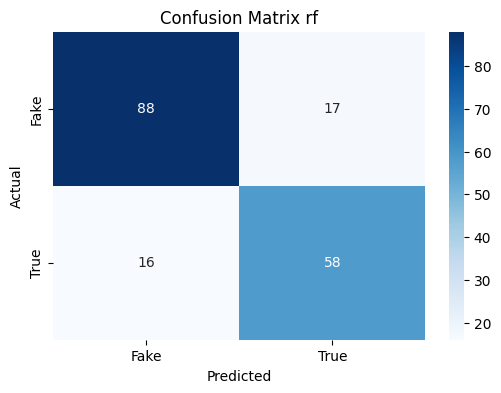

In [97]:
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, fmt="d", cmap="Blues", xticklabels=["Fake", "True"], yticklabels=["Fake", "True"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix rf")
plt.show()

In [98]:
def objective_rf(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    max_depth = trial.suggest_int('max_depth', 3, 50)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])
    class_weight = trial.suggest_categorical('class_weight', [None, 'balanced'])

    model = RandomForestClassifier(
        n_estimators=n_estimators, max_depth=max_depth, max_features=max_features,
        min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
        bootstrap=bootstrap, class_weight=class_weight, random_state=42
    )
    score = cross_val_score(model, x_train_sm, y_train_sm, cv=3, scoring='accuracy').mean()
    return score

In [99]:
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler())  # We aim to maximize accuracy
study.optimize(objective_rf, n_trials=50)  # Run 50 trials to find the best hyperparameters

[I 2025-09-18 19:04:17,868] A new study created in memory with name: no-name-75e13c82-b497-4665-bd1a-13afb966682b
[I 2025-09-18 19:04:19,490] Trial 0 finished with value: 0.8355855855855857 and parameters: {'n_estimators': 326, 'max_depth': 11, 'max_features': 'log2', 'min_samples_split': 6, 'min_samples_leaf': 1, 'bootstrap': True, 'class_weight': None}. Best is trial 0 with value: 0.8355855855855857.
[I 2025-09-18 19:04:20,685] Trial 1 finished with value: 0.831081081081081 and parameters: {'n_estimators': 270, 'max_depth': 46, 'max_features': 'sqrt', 'min_samples_split': 6, 'min_samples_leaf': 8, 'bootstrap': True, 'class_weight': None}. Best is trial 0 with value: 0.8355855855855857.
[I 2025-09-18 19:04:21,994] Trial 2 finished with value: 0.8288288288288288 and parameters: {'n_estimators': 298, 'max_depth': 13, 'max_features': 'log2', 'min_samples_split': 10, 'min_samples_leaf': 8, 'bootstrap': True, 'class_weight': None}. Best is trial 0 with value: 0.8355855855855857.
[I 2025-09

In [100]:
print(f'Best trial accuracy: {study.best_trial.value}')

print(f'Best hyperparameters: {study.best_trial.params}') # 82.86, 0.7910, 84.57

Best trial accuracy: 0.8445945945945946
Best hyperparameters: {'n_estimators': 132, 'max_depth': 21, 'max_features': 'log2', 'min_samples_split': 2, 'min_samples_leaf': 4, 'bootstrap': True, 'class_weight': None}


In [101]:
rfs = RandomForestClassifier(n_estimators=132, max_depth=21, max_features='log2',min_samples_split=2,min_samples_leaf=4,bootstrap=True,class_weight=None)
rfs.fit(x_train_sm,y_train_sm)
print(accuracy_score(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

0.8156424581005587
[[88 17]
 [16 58]]


In [47]:
gb = GradientBoostingClassifier()
gb.fit(x_train,y_train)
y_pred = gb.predict(x_test)
print(accuracy_score(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))
print(cross_val_score(gb,x_train,y_train,cv=3,scoring='accuracy').mean()) #82.68,0.81 --- 0.798, 0.813---82.12,81.3

0.8268156424581006
[[93 12]
 [19 55]]
0.8104043305085747


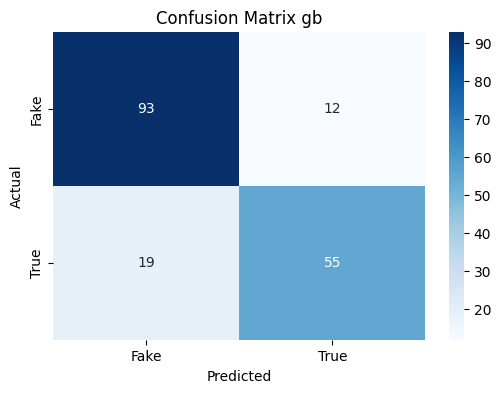

In [48]:
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, fmt="d", cmap="Blues", xticklabels=["Fake", "True"], yticklabels=["Fake", "True"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix gb")
plt.show()

In [49]:
def objective_gb(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.5)
    max_depth = trial.suggest_int('max_depth', 2, 10)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    subsample = trial.suggest_float('subsample', 0.5, 1.0)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])

    model = GradientBoostingClassifier(
        n_estimators=n_estimators, learning_rate=learning_rate,
        max_depth=max_depth, min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf, subsample=subsample,
        max_features=max_features, random_state=42
    )
    score = cross_val_score(model, x_train_sm, y_train_sm, cv=3, scoring='accuracy').mean()
    return score



In [50]:
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler())  # We aim to maximize accuracy
study.optimize(objective_gb, n_trials=50)  # Run 50 trials to find the best hyperparameters

[I 2025-09-18 18:52:26,768] A new study created in memory with name: no-name-a5859151-e804-4ec3-ad46-92c4c19cd327
[I 2025-09-18 18:52:27,992] Trial 0 finished with value: 0.8310810810810811 and parameters: {'n_estimators': 287, 'learning_rate': 0.1033470607752484, 'max_depth': 4, 'min_samples_split': 18, 'min_samples_leaf': 1, 'subsample': 0.6743511484633713, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.8310810810810811.
[I 2025-09-18 18:52:30,629] Trial 1 finished with value: 0.8423423423423423 and parameters: {'n_estimators': 239, 'learning_rate': 0.040561852659777464, 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 1, 'subsample': 0.6553282186532146, 'max_features': 'log2'}. Best is trial 1 with value: 0.8423423423423423.
[I 2025-09-18 18:52:33,371] Trial 2 finished with value: 0.8175675675675675 and parameters: {'n_estimators': 226, 'learning_rate': 0.48045474836288443, 'max_depth': 9, 'min_samples_split': 5, 'min_samples_leaf': 4, 'subsample': 0.8105377397106

In [51]:
ds_param_gb = study.best_trial.params

In [52]:
print(f'Best trial accuracy: {study.best_trial.value}')
print(f'Best hyperparameters: {study.best_trial.params}') #83, 78ds, 84.45

Best trial accuracy: 0.8434684684684686
Best hyperparameters: {'n_estimators': 317, 'learning_rate': 0.014122324100186351, 'max_depth': 7, 'min_samples_split': 3, 'min_samples_leaf': 5, 'subsample': 0.6065863567562002, 'max_features': 'log2'}


In [53]:
gbs = GradientBoostingClassifier(n_estimators=115, learning_rate=0.03798282131773404,max_depth=10,min_samples_split=4,min_samples_leaf=8,subsample=0.5177638593542816,max_features='log2')
gbs.fit(x_train_sm,y_train_sm)
y_pred = gbs.predict(x_test)
print(accuracy_score(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

0.8100558659217877
[[89 16]
 [18 56]]


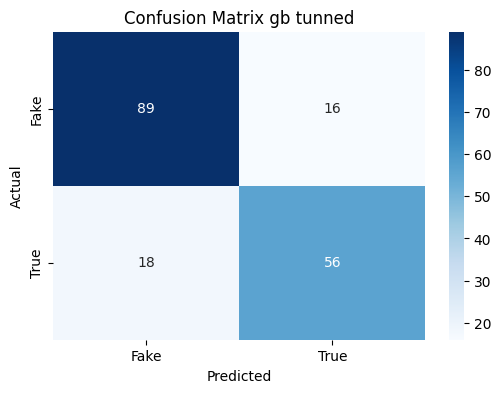

In [54]:
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, fmt="d", cmap="Blues", xticklabels=["Fake", "True"], yticklabels=["Fake", "True"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix gb tunned")
plt.show()

In [ ]:
gb_param_sm = study.best_trial.params

In [55]:
from sklearn.neighbors import KNeighborsClassifier

In [56]:
kn = KNeighborsClassifier()
kn.fit(x_train_ds,y_train_ds)
y_pred = kn.predict(x_test)
print(accuracy_score(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))
print(cross_val_score(kn,x_train,y_train,cv=3,scoring='accuracy').mean()) #0.70,0.67 -- 72,0.67--0.66,0.67

0.7206703910614525
[[74 31]
 [19 55]]
0.6755487004928553


In [57]:

def objective_knn(trial):
    n_neighbors = trial.suggest_int('n_neighbors', 1, 50)
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    metric = trial.suggest_categorical('metric', ['euclidean', 'manhattan', 'minkowski'])
    p = trial.suggest_int('p', 1, 2) if metric == 'minkowski' else 2

    model = KNeighborsClassifier(
        n_neighbors=n_neighbors, weights=weights,
        metric=metric, p=p
    )
    score = cross_val_score(model, x_train_ds, y_train_ds, cv=3, scoring='accuracy').mean()
    return score

In [58]:
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler())  # We aim to maximize accuracy
study.optimize(objective_knn, n_trials=50)  # Run 50 trials to find the best hyperparameters

[I 2025-09-18 18:54:38,239] A new study created in memory with name: no-name-3fe7edee-5860-435d-ac88-e56a887b4958
[I 2025-09-18 18:54:38,267] Trial 0 finished with value: 0.7182955662963195 and parameters: {'n_neighbors': 28, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 0 with value: 0.7182955662963195.
[I 2025-09-18 18:54:38,291] Trial 1 finished with value: 0.6492582595777624 and parameters: {'n_neighbors': 33, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 0 with value: 0.7182955662963195.
[I 2025-09-18 18:54:38,313] Trial 2 finished with value: 0.6884480990940096 and parameters: {'n_neighbors': 25, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 0 with value: 0.7182955662963195.
[I 2025-09-18 18:54:38,338] Trial 3 finished with value: 0.6306676709978448 and parameters: {'n_neighbors': 12, 'weights': 'uniform', 'metric': 'minkowski', 'p': 2}. Best is trial 0 with value: 0.7182955662963195.
[I 2025-09-18 18:54:38,365] Trial 4 finished with va

In [59]:
print(f'Best trial accuracy: {study.best_trial.value}')
print(f'Best hyperparameters: {study.best_trial.params}') #0.73,0.72---0.79

Best trial accuracy: 0.7220199610821668
Best hyperparameters: {'n_neighbors': 23, 'weights': 'distance', 'metric': 'manhattan'}


In [60]:
kns = KNeighborsClassifier(n_neighbors=6, weights='distance',metric='manhattan')
kns.fit(x_train_sm,y_train_sm)
y_pred = kns.predict(x_test)
print(accuracy_score(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

0.7094972067039106
[[79 26]
 [26 48]]


In [61]:
kn_param_sm = study.best_trial.params

In [62]:
ds_kn_param = study.best_trial.params

In [63]:
sv = SVC()
sv.fit(x_train_ds,y_train_ds)
y_pred = sv.predict(x_test)
print(accuracy_score(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))
print(cross_val_score(sv,x_train,y_train,cv=3,scoring='accuracy').mean()) #65,66 --- 70,66---71

0.7094972067039106
[[77 28]
 [24 50]]
0.6656856835561228


In [64]:
print(accuracy_score(y_test,lgs.predict(x_test)))
print(accuracy_score(y_test,ads.predict(x_test)))
print(accuracy_score(y_test,dts.predict(x_test)))
print(accuracy_score(y_test,rfs.predict(x_test)))
print(accuracy_score(y_test,gbs.predict(x_test)))
print(accuracy_score(y_test,kn.predict(x_test)))

0.8044692737430168
0.8268156424581006
0.8268156424581006
0.8268156424581006
0.8100558659217877
0.7206703910614525


In [114]:
from sklearn.ensemble import StackingClassifier
base_learners = [
    ('rf', rfs),
    ('gb',gbs),
    ('lr',lgs),
    ('ada',ads),
    ('dt',dts),
    ('svc',sv),

]

# Meta learner
meta_learner = LogisticRegression()
#meta_learner = KNeighborsClassifier()
#meta_learner = SVC()

# Stacking Classifier
stack = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_learner,
    passthrough=False  # if True, meta learner also gets original features
)

In [124]:
stack.fit(x_train_ds,y_train_ds)
y_pred = stack.predict(x_test)
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))

[[89 16]
 [ 9 65]]
0.8603351955307262


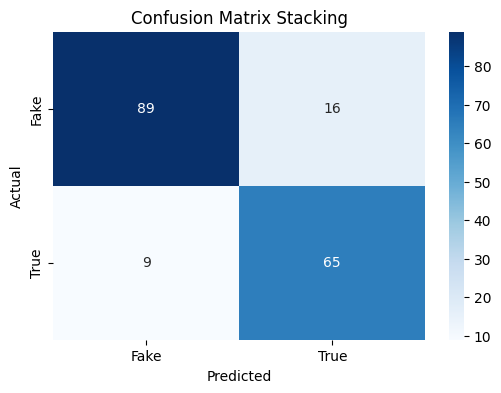

In [125]:
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, fmt="d", cmap="Blues", xticklabels=["Fake", "True"], yticklabels=["Fake", "True"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix Stacking")
plt.show()

In [168]:
df2 = pd.read_csv('/content/test.csv')

In [169]:
df2.drop(['Name','Ticket','Cabin','SibSp','Parch','Cabin'],axis=1,inplace=True)

In [170]:
df2.sample()

,PassengerId,Pclass,Sex,Age,Fare,Embarked
56,948,3,male,35.0,7.8958,S


In [171]:
df2.isnull().sum()

,0
PassengerId,0
Pclass,0
Sex,0
Age,86
Fare,1
Embarked,0


In [172]:
df2['Fare'].fillna(df2['Fare'].mean(),inplace=True)

/tmp/ipython-input-4187703575.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2['Fare'].fillna(df2['Fare'].mean(),inplace=True)


In [173]:
df2['Age'].fillna(df2['Age'].mean(),inplace=True)

/tmp/ipython-input-3242819075.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2['Age'].fillna(df2['Age'].mean(),inplace=True)


In [175]:
df2['Sex'] = df2['Sex'].map({'male':0,'female':1})

In [176]:
df2['Embarked'] = df2['Embarked'].map({'S':0,'C':1,'Q':2})

In [177]:
df2.head()

,PassengerId,Pclass,Sex,Age,Fare,Embarked
0,892,3,0,34.5,7.8292,2
1,893,3,1,47.0,7.0000,0
2,894,2,0,62.0,9.6875,2
3,895,3,0,27.0,8.6625,0
4,896,3,1,22.0,12.2875,0


In [178]:
df_test = df2.drop('PassengerId',axis=1)

In [179]:
predictions = stack.predict(df_test)

In [180]:
submissiontitanic = pd.DataFrame({
    'PassengerId': df2['PassengerId'],  # original IDs from test dataset
    'Survived': predictions
})

In [182]:
submissiontitanic.to_csv('submissiontitanic.csv', index=False)

In [184]:
prediciton2 = gbs.predict(df_test)
submissiontitanic2 = pd.DataFrame({
    'PassengerId': df2['PassengerId'],  # original IDs from test dataset
    'Survived': prediciton2
})


In [185]:
submissiontitanic2.to_csv('submissiontitanic2.csv', index=False)